# **High-Frequency Quasi-Periodic Oscillations in the Solar Corona Observed with High-Frame-Rate Imaging During the 2023 Total Solar Eclipse**
### **Data Processing and Analysis Notebook**

**Authors**: [Yu Liang]
**Affiliation**: [Shanghai Astronomical Observatory, Chinese Academy of Sciences, Shanghai 200030, China]  
**Contact**: [yuliang@shao.ac.cn]  
**Last Updated**: [2024-12-10]  

---

### **Notebook Overview**

These Jupyter Notebook documents the processing and analysis of observational data collected during the 2023 total solar eclipse. The primary objectives of this Notebook include:

1. Preprocessing of raw white-light corona imaging data (dark field subtraction, flat field correction, and temporal registration).
2. Application of wavelet analysis to detect high-frequency quasi-periodic oscillations (HFQPOs).
3. Visualizations of the solar corona and statistical results for Sun-as-a-star analysis.

---

### **Dependencies**

The analysis relies on the following Python libraries (compatible versions):  
- `numpy==1.2.43`  
- `pandas==1.5.1`  
- `scikit-image==0.20.0`  
- `matplotlib==3.7.1`  
- `astropy==5.1.1`  
- `opencv-python==4.7.0.72`  
- `Pillow==9.2.0`  
- `scipy==1.13.1`  


<!-- A complete list of dependencies can be found in the accompanying `requirements.txt`. -->

---

### **Data Source**

- **Observation Site**: Learmonth Airport, Australia  
- **Instrument**: iPhone with 565 nm filter, sampling at 240 fps, frams width * height: 720.0 * 1280.0, image shape:(1280, 720, 3)  
- **Date**: April 20, 2023  

---

### **Main Structure**

- **Section 1**: Data loading and inspection  
- **Section 2**: Preprocessing (dark field, flat field, and registration)  
- **Section 3**: Wavelet analysis and signal detection  
- **Section 4**: Results visualization and discussion  

---
### **Notebook figure - Polar form coronal image**
#### The Polar form coronal image. 

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from astropy.io import fits
import skimage.io as io 
import struct
import imageio as iio
from skimage import data
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift
import cv2
from PIL import Image
import glob

In [33]:
path0 = '/Volumes/WD1T/share/TSE2023/'                  # input dir
path1 = '/Volumes/WD1T/share/TSE2023/iPhone/result/'    # input dir
pathpol  = path1 + 'pol_rot_r2dfdata/'                  # pahtfd = path with flat and dark processed
dirr2t = path1 + 'r2dfdatat/'  # r1dfdatat: registration 1st dark flat data totally

outputpath = './output/'

In [34]:
# delete ._* files
files_to_delete = glob.glob(os.path.join(pathpol, '._*'))

for file in files_to_delete:
    try:
        os.remove(file)
        print(f"Deleted: {file}")
    except Exception as e:
        print(f"Error deleting {file}: {e}")
        
# delete ._* files
files_to_delete = glob.glob(os.path.join(dirr2t , '._*'))

for file in files_to_delete:
    try:
        os.remove(file)
        print(f"Deleted: {file}")
    except Exception as e:
        print(f"Error deleting {file}: {e}")

In [35]:
# preview
pathd = pathpol
listd = os.listdir(pathd)
listd.sort()
print(listd[0:10])
print(len(listd))
st = 0
fn = len(listd) - st

['pol_rot_r2_r1_image_00000.fits', 'pol_rot_r2_r1_image_00001.fits', 'pol_rot_r2_r1_image_00002.fits', 'pol_rot_r2_r1_image_00003.fits', 'pol_rot_r2_r1_image_00004.fits', 'pol_rot_r2_r1_image_00005.fits', 'pol_rot_r2_r1_image_00006.fits', 'pol_rot_r2_r1_image_00007.fits', 'pol_rot_r2_r1_image_00008.fits', 'pol_rot_r2_r1_image_00009.fits']
13301


155 360


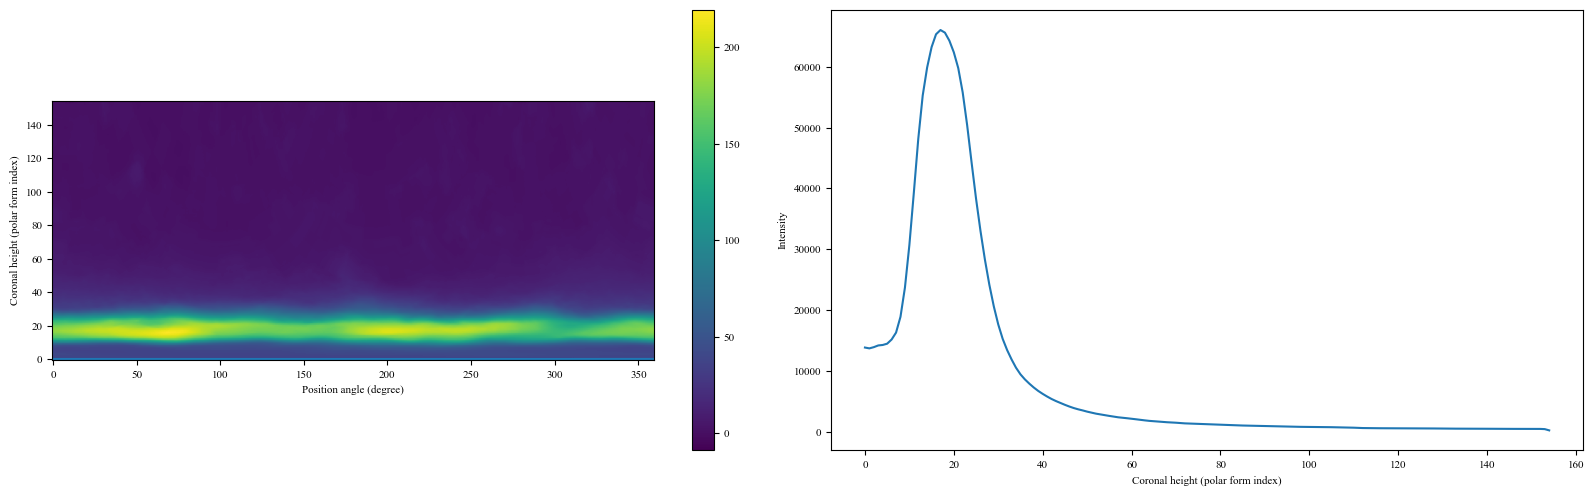

In [36]:
hdu = fits.open(pathd + listd[st + 6000])
img = hdu[0].data
pimg = img 
m,n = pimg.shape
print(m,n)
rp = np.sum(pimg,axis=1)
cp = np.sum(pimg,axis=0)
ridx = np.argmax(rp[0:100])

plt.figure(figsize=[16,5])
plt.subplot(121)
plt.imshow(img,origin='lower')
plt.xlabel('Position angle (degree)')
plt.ylabel('Coronal height (polar form index)')
# plt.axhline(y=138, color='r', linestyle='--', linewidth=2)
# plt.axhline(y=153, color='r', linestyle='--', linewidth=2)
plt.axhline()
plt.colorbar()
plt.subplot(122)
plt.plot(rp)             # between 1.006 and 4.5 R_sun
plt.xlabel('Coronal height (polar form index)')
plt.ylabel('Intensity')
plt.tight_layout()
plt.show()

In [37]:
pimg = img.copy()
rp.shape, img.shape

((155,), (155, 360))

Fitted parameters: a = 1067580.20, b = 0.1378, c = 1020.67Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.



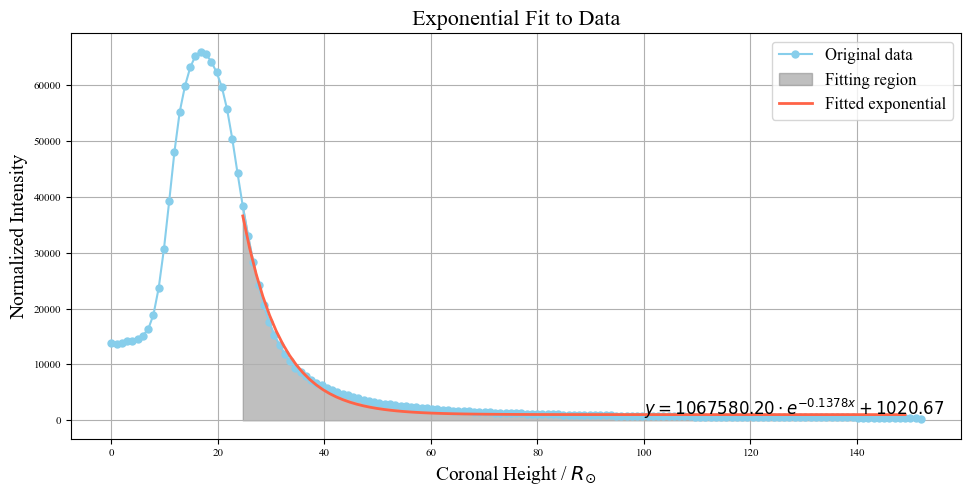

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Assumed data
m,n = img.shape
szrp = m   # Length of rp
x = np.linspace(0, int(9 * ridx / 1.006), szrp)  # Generate x values
#x = np.linspace(0, 9, szrp)  # Generate x values

# Define your actual data
# rp = np.array([...])  # Placeholder for actual data

# Define the exponential decay function model: y = a * exp(-b * x) + c
def exponential_func(x, a, b, c):
    return a * np.exp(-b * x) + c

# Select fitting interval
start_index = int(ridx / 1.006 * 1.5)
end_index = int(ridx / 1.006 * 9.0)

# Ensure start_index and end_index are within valid range
start_index = min(start_index, szrp - 1)
end_index = min(end_index, szrp - 1)

# Fit data
x_data, y_data = x[start_index:end_index], rp[start_index:end_index]

# Initial parameter guess (set according to the exponential decay characteristics)
p0 = [np.max(y_data), 0.1, np.min(y_data)]  # a = max value, b = decay rate, c = offset

# Use curve_fit to fit
params, covariance = curve_fit(exponential_func, x_data, y_data, p0=p0, maxfev=10000)

# Print the fitted parameters
print("Fitted parameters: a = {:.2f}, b = {:.4f}, c = {:.2f}".format(params[0], params[1], params[2]))

# Generate the fitted curve data
x_fit = np.linspace(x[start_index], x[end_index - 1], 100)
y_fit = exponential_func(x_fit, *params)

# Plot the data and fitted curve
plt.figure(figsize=(10, 5))
plt.plot(x, rp, 'o-', label='Original data', color='skyblue', markersize=5)
plt.fill_between(x[start_index:end_index], rp[start_index:end_index], color='grey', alpha=0.5, label='Fitting region')

# Plot the fitted exponential decay curve
plt.plot(x_fit, y_fit, color='tomato', label='Fitted exponential', linewidth=2)

# Set labels and title
plt.xlabel('Coronal Height / $R_{\odot}$', fontsize=14)
plt.ylabel('Normalized Intensity', fontsize=14)
plt.title('Exponential Fit to Data', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# Annotate the fitted equation on the plot
fit_equation = f'$y = {params[0]:.2f} \cdot e^{{-{params[1]:.4f} x}} + {params[2]:.2f}$'
plt.text(x_fit[int(len(x_fit) * 0.6)], y_fit[int(len(y_fit) * 0.6)], fit_equation, fontsize=12, color='black')

plt.tight_layout()
plt.show()

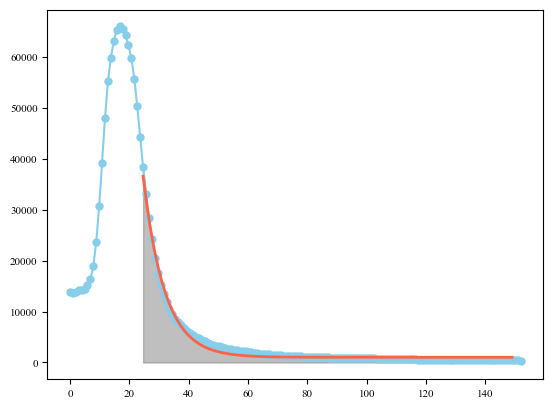

In [39]:
plt.plot(x, rp, 'o-', label='Original data', color='skyblue', markersize=5)
plt.fill_between(x[start_index:end_index], rp[start_index:end_index], color='grey', alpha=0.5, label='Fitting region')

# 绘制拟合曲线
plt.plot(x_fit, y_fit, color='tomato', label='Fitted exponential', linewidth=2)
plt.show()

In [40]:
# 5.0 data dark processing
pathd = dirr2t 
listd = os.listdir(pathd)
listd.sort()
print(listd[0:10])
print(len(listd))
st = 0
fn = len(listd) - st

['r2_r1_image_00000.fits', 'r2_r1_image_00001.fits', 'r2_r1_image_00002.fits', 'r2_r1_image_00003.fits', 'r2_r1_image_00004.fits', 'r2_r1_image_00005.fits', 'r2_r1_image_00006.fits', 'r2_r1_image_00007.fits', 'r2_r1_image_00008.fits', 'r2_r1_image_00009.fits']
13301


In [41]:
def rotimg(img2, cr, cc):
    img2 = img2 + 10
    sxy = 1             # Scaling factor
    rxy = -30          # Rotation angle needed for visual registration
    m, n = img2.shape
    matrix = cv2.getRotationMatrix2D((cr, cc), rxy, sxy)
    rimg2 = cv2.warpAffine(img2, matrix, (m, n))
    rimg2 = rimg2.astype('float32')
    rimg2 -= 10
    return rimg2

import math

def hstackpolar(img):
    m, n = img.shape
    img1 = np.zeros([m, n])
    for i in range(m):
        iml1 = img[i, 0:270]
        iml2 = img[i, 270:361]
        iml = np.concatenate((iml2, iml1), axis=0) 
        img1[i, :] = iml
    return img1

def polarimg(img, cr, cc):    
    csv = int(361 / 2)
    csv1 = 500 - 361
    # sr, er, sc, ec = 160, 280, 180, 300
    # u, l, le, ri = 33 + sr, 98 + sr, 165, 331
    # cc, cr = int((u + l) / 2), int((le + ri) / 2)
    centy = cc - (csv1)
    centx = cr - (csv1)
    radius = cr
    img = img[cc - csv: cc + csv + 1, cr - csv: cr + csv + 1]
    img = img.astype('float32')
    h, w = img.shape
    centy = csv
    centx = csv
    cx, cy = csv + 1, csv + 1
    # print('cx, cy are:', cx, cy)
    dim = (w, h)
    maxRadius = math.hypot(radius, radius)
    out = cv2.linearPolar(img, (centx, centy), maxRadius, cv2.WARP_FILL_OUTLIERS + cv2.INTER_LINEAR)
    tout = np.transpose(out)
    ftout = cv2.flip(tout, 1)
    htout = hstackpolar(ftout)
    htout = htout.astype('float32')
    return htout


In [42]:
hdu2 = fits.open(pathd + listd[6000])
img2 = hdu2[0].data

def rotimg(img2, cr, cc, degree):
    img2 = img2 + 10
    sxy = 1  # Scaling factor
    rxy = degree  # Rotation angle required for visual alignment
    m, n = img2.shape
    matrix = cv2.getRotationMatrix2D((cr, cc), rxy, sxy)
    rimg2 = cv2.warpAffine(img2, matrix, (m, n))
    rimg2 = rimg2.astype('float32')
    rimg2 -= 10
    return rimg2
import math
m,n = img2.shape
cr, cc = int(m/2), int(n/2)
r12img = rotimg(img2, cr, cc, 170)

frame 6000 loaded.


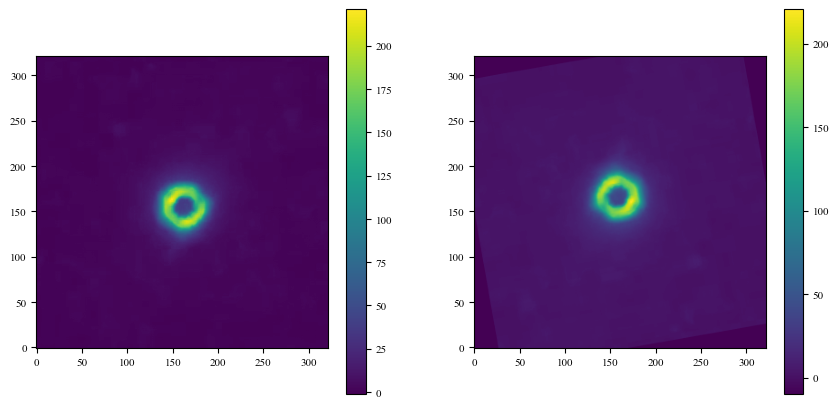

In [43]:
for i in range(6000,6001):
    hdu = fits.open(pathd + listd[st + i])
    print('frame', i, 'loaded.')  
    img = hdu[0].data
    cimg = img#[sr0:er0,sc0:ec0]
plt.figure(figsize = [16,5],num = 'img, rimg, pimg')
plt.subplot(131)
plt.imshow(cimg, origin = 'lower')
plt.colorbar()
plt.subplot(132)
plt.imshow(r12img, origin = 'lower')
plt.colorbar()

In [44]:
# Define the exponential decay function model: y = a * exp(-b * x) + c
def exponential_func(x, a, b, c):
    return a * np.exp(-b * x) + c


nrp = rp / np.max(rp)

# Select the fitting range
start_index = int(ridx / 1.006 * 1.5)
end_index = int(ridx / 1.006 * 9.0)

# Ensure that start_index and end_index are within the valid range
start_index = min(start_index, szrp - 1)
end_index = min(end_index, szrp - 1)

# Fit the data
x_data, y_data = x[start_index:end_index], nrp[start_index:end_index]

# Initial parameter guess (set according to the exponential decay characteristics)
p0 = [np.max(y_data), 0.1, np.min(y_data)]  # a = maximum value, b = decay rate, c = offset

# Use curve_fit for fitting
params, covariance = curve_fit(exponential_func, x_data, y_data, p0=p0, maxfev=10000)

# Print the fitted parameters
print("Fitted parameters: a = {:.2f}, b = {:.4f}, c = {:.2f}".format(params[0], params[1], params[2]))

# Generate the fitted curve data
x_fit = np.linspace(x[start_index], x[end_index - 1], 100)
y_fit = exponential_func(x_fit, *params)


Fitted parameters: a = 16.17, b = 0.1378, c = 0.02
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [45]:
# # Define the exponential decay function model: y = a * exp(-b * x) + c
# def exponential_func(x, a, b, c):
#     return a * np.exp(-b * x) + c

# nrp = rp / np.max(rp)

# # Select the fitting range
# start_index = int(ridx / 1.006 * 1.5)
# end_index = int(ridx / 1.006 * 9.0)

# # Ensure that start_index and end_index are within the valid range
# start_index = min(start_index, szrp - 1)
# end_index = min(end_index, szrp - 1)

# # Fit the data
# x_data, y_data = x[start_index:end_index], nrp[start_index:end_index]

# # Initial parameter guess (set according to the exponential decay characteristics)
# p0 = [np.max(y_data), 0.1, np.min(y_data)]  # a = maximum value, b = decay rate, c = offset

# # Use curve_fit for fitting
# params, covariance = curve_fit(exponential_func, x_data, y_data, p0=p0, maxfev=10000)

# # Print the fitted parameters
# print("Fitted parameters: a = {:.2f}, b = {:.4f}, c = {:.2f}".format(params[0], params[1], params[2]))

# # Generate the fitted curve data
# x_fit = np.linspace(x[start_index], x[end_index - 1], 100)
# y_fit = exponential_func(x_fit, *params)

# rm, rn = r12img.shape
# cc,cr = int(rn/2), int(rm/2)

# from matplotlib.patches import Rectangle, Circle
# import matplotlib.pyplot as plt
# import numpy as np

# # Create a figure window
# plt.figure(figsize=[10, 6], num='img, rimg, pimg', dpi=300)

# # -------------------------
# # Subplot 1: Display preprocessed corona image
# # -------------------------
# plt.subplot(221)
# ax = plt.gca()
# ax.imshow(r12img, cmap='gray', origin='lower')

# # Define the bottom-left corner, width, and height of the rectangle
# xp, yp, width, height = 30,30,20,20
# rbkg = round(((cc - 40)**2 + (cr - 40)**2) ** 0.5 / ridx * 1.006, 2)
# print('The distance of the sky background selected for analysis',rbkg)
# # Add the rectangle to the axis
# rect = Rectangle((xp, yp), width, height, linewidth=1, edgecolor='red', facecolor='none')
# ax.add_patch(rect)

# # Define the center coordinates and radius of the circle
# center_x, center_y, radius = cc, cr, int(ridx / 1.006 * 9.0)
# # Add the circle to the axis
# circle = Circle((center_x, center_y), radius, linewidth=2, edgecolor='yellow', facecolor='none')
# ax.add_patch(circle)

# # Set title and labels
# plt.axis('off')
# plt.title('Preprocessed corona', fontsize=14)
# plt.xlabel('Position Angle  / $\circ$', fontsize=14)
# plt.ylabel('Coronal Height', fontsize=14)

# # -------------------------
# # Subplot 2: Display polarized corona image
# # -------------------------
# plt.subplot(222)
# plt.imshow(pimg, cmap='gray', origin='lower')

# # Set Y-axis ticks and labels
# y_ticks = np.arange(0, 154, 17)  # Generate ticks from 0 to 8 with intervals
# y_labels = ['0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0']  # Corresponding labels
# plt.yticks(y_ticks, y_labels)

# # Set title and labels
# plt.xlabel('Position Angle / $\circ$', fontsize=14)
# plt.ylabel('Coronal Height / $R_{\odot}$', fontsize=14)
# plt.title('Polar corona', fontsize=14)

# # -------------------------
# # Subplot 3: Plot the fitting curve
# # -------------------------
# plt.subplot(223)
# plt.plot(x, nrp, 'o-', label='Original data', color='skyblue', markersize=5)
# plt.fill_between(x[start_index:end_index], nrp[start_index:end_index], color='grey', alpha=0.5, label='Fitting region')

# # Plot the fitted curve
# plt.plot(x_fit, y_fit, color='tomato', label='Fitted exponential', linewidth=2)
# x_ticks = np.arange(0, 154, 17)  # Generate ticks from 0 to 8 with intervals
# # Set X and Y-axis ticks and labels
# plt.xticks(x_ticks, y_labels)
# plt.yticks(fontsize=12)
# plt.xlabel('Coronal Height / $R_{\odot}$', fontsize=14)
# plt.ylabel('Normalized Intensity', fontsize=14)
# plt.legend(fontsize=12)

# # Add the fitting equation to the plot
# fit_equation = f'$y = {params[0]:.2f} \cdot e^{{-{params[1]:.4f} x}} + {params[2]:.2f}$'
# plt.text(45, 0.3, fit_equation, fontsize=14, color='black')

# # -------------------------
# # Subplot 4: Display normalized intensity distribution
# # -------------------------
# plt.subplot(224)
# plt.plot(cp / np.max(cp))

# # Set X and Y-axis ticks and labels
# y_ticks = np.arange(0, 361, 90)
# plt.xticks(y_ticks, ['North', 'West', 'South', 'East', 'North'])
# plt.xlim([0, 361])
# plt.xlabel('Position Angle / $\circ$', fontsize=14)
# plt.ylabel('Normalized Intensity', fontsize=14)

# # -------------------------
# # Adjust layout and save
# # -------------------------
# plt.tight_layout()
# pathfigs = './output/'
# plt.savefig(pathfigs + 'ROI.png', bbox_inches='tight')
# plt.show()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


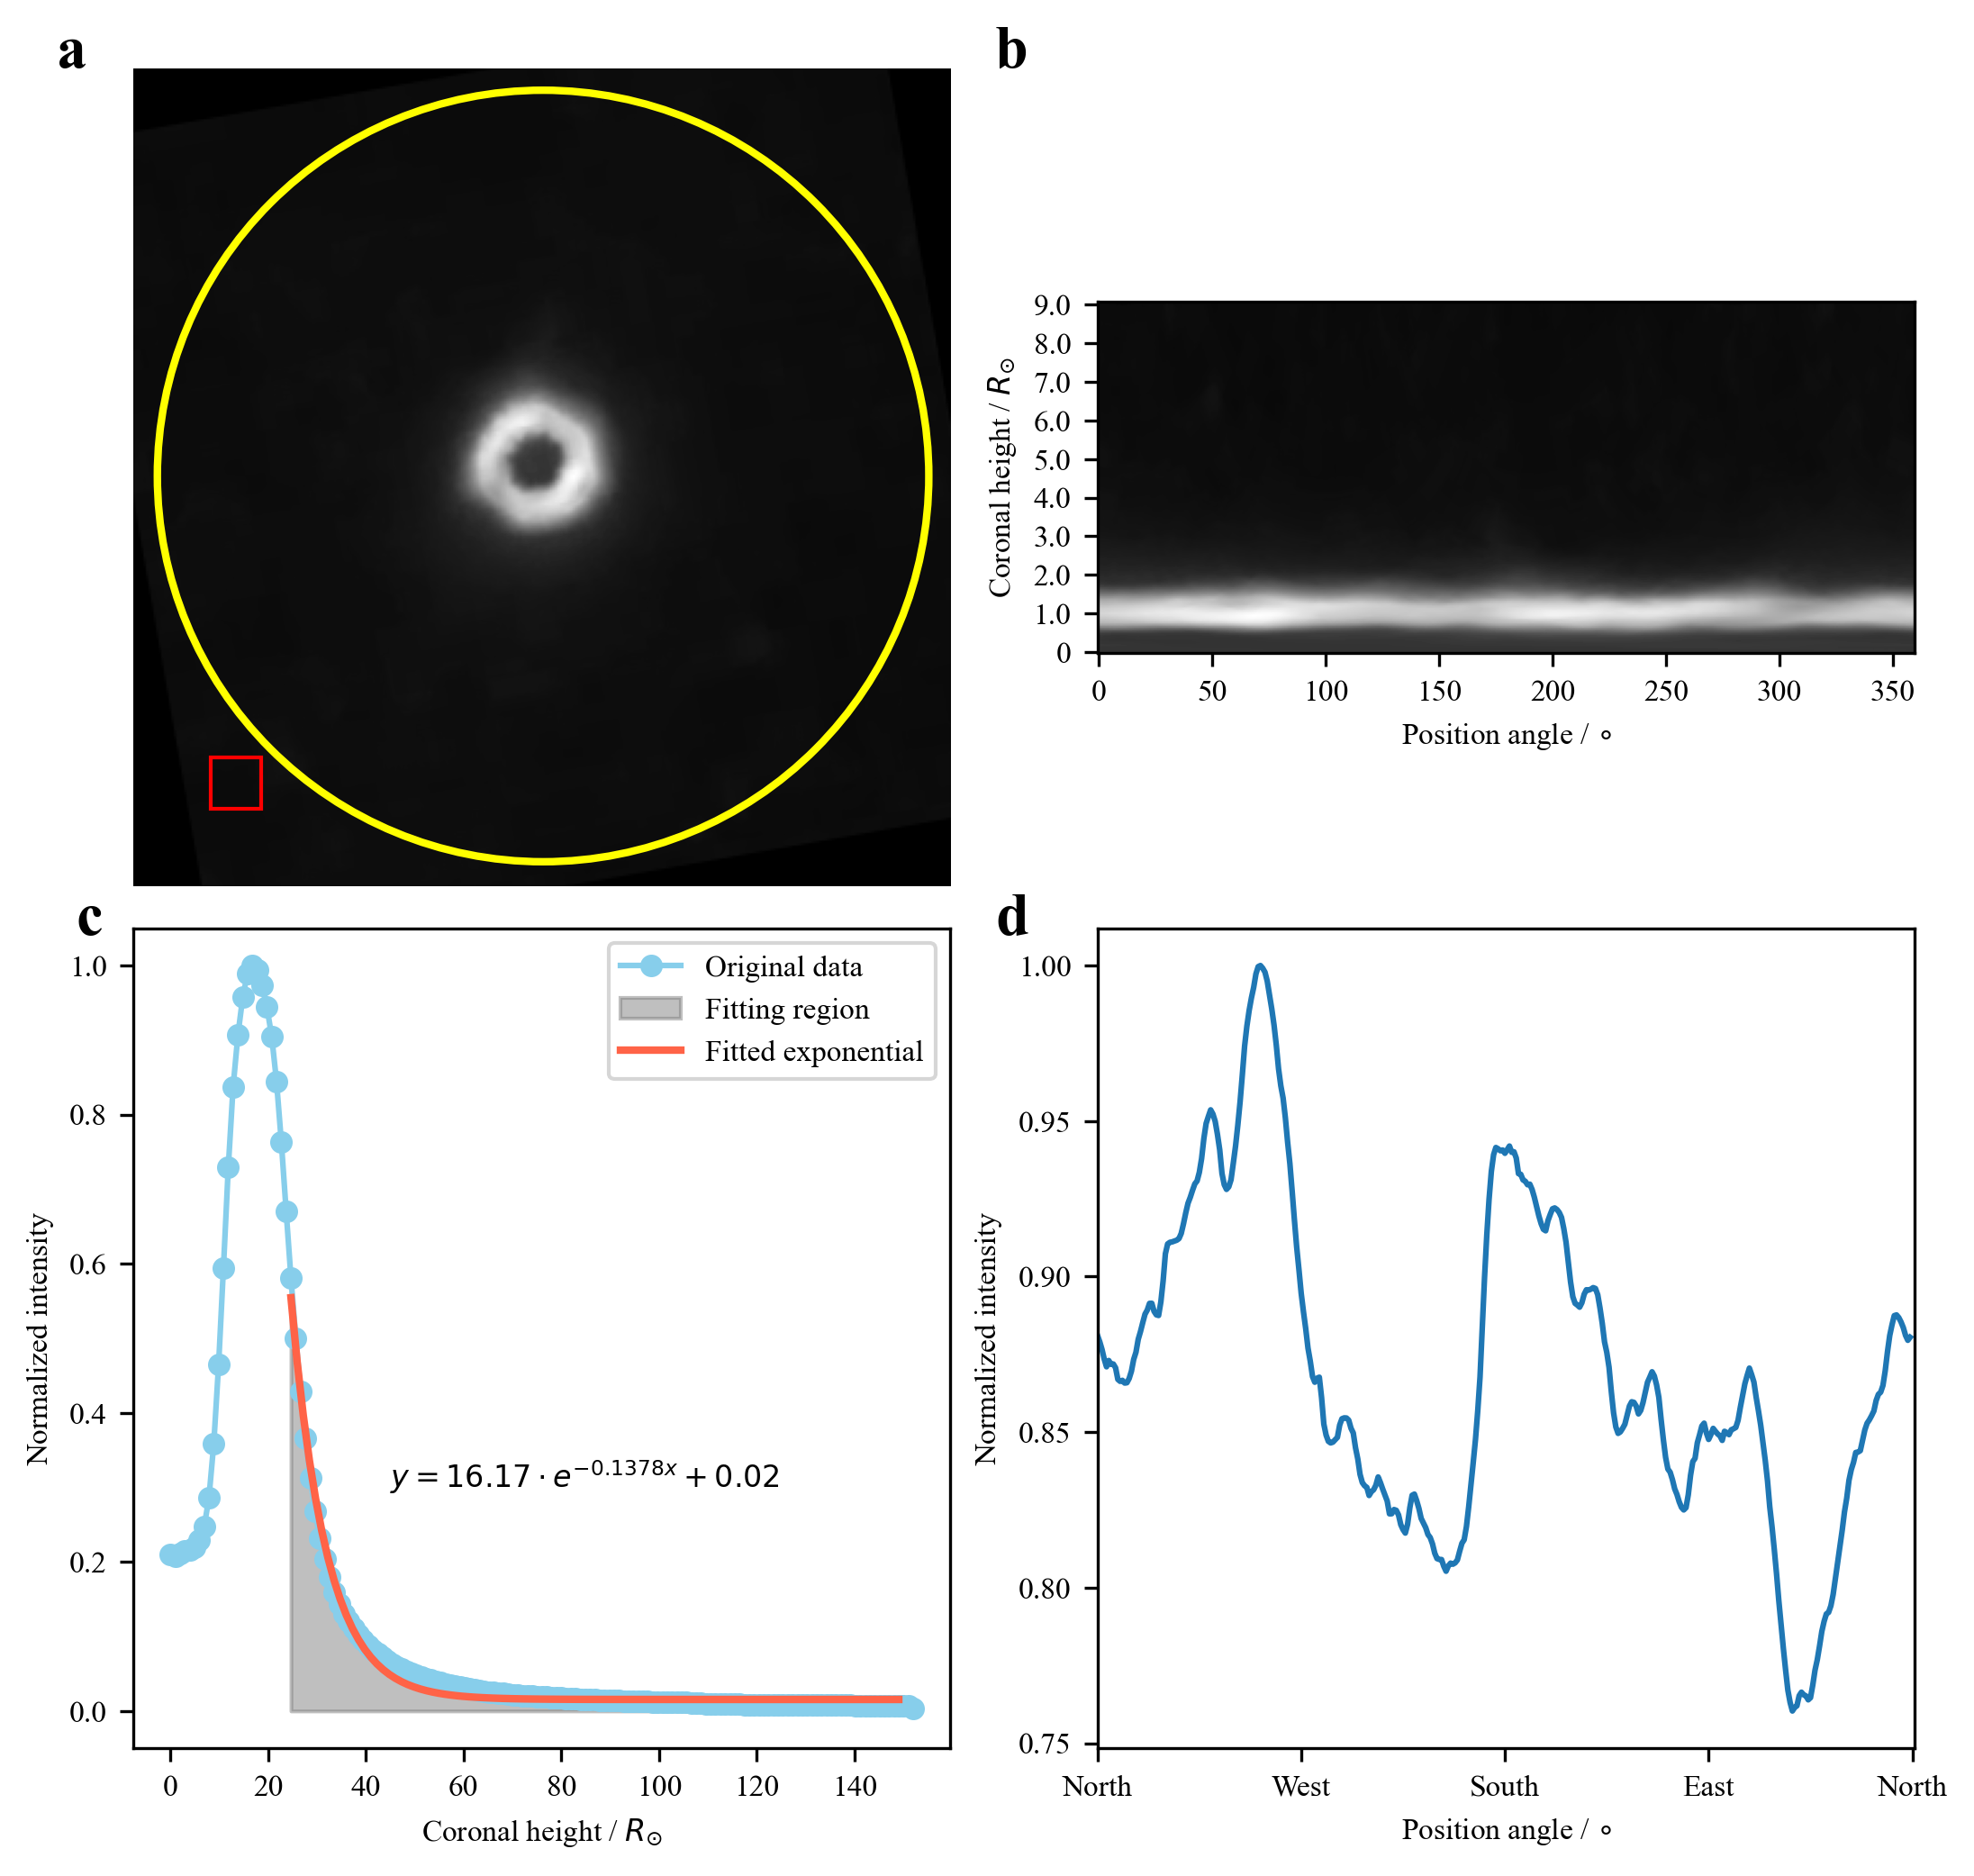

In [46]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import numpy as np
from scipy.optimize import curve_fit

# Set global font to Times New Roman, font size 8
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 8

# Define the exponential decay model
def exponential_func(x, a, b, c):
    return a * np.exp(-b * x) + c

# Data processing and fitting
nrp = rp / np.max(rp)
start_index = min(int(ridx / 1.006 * 1.5), szrp - 1)
end_index = min(int(ridx / 1.006 * 9.0), szrp - 1)
x_data, y_data = x[start_index:end_index], nrp[start_index:end_index]
p0 = [np.max(y_data), 0.1, np.min(y_data)]
params, _ = curve_fit(exponential_func, x_data, y_data, p0=p0, maxfev=10000)
x_fit = np.linspace(x[start_index], x[end_index - 1], 100)
y_fit = exponential_func(x_fit, *params)

# Create canvas and subplots for a double-column layout
plt.figure(figsize=[7.09, 6.69], dpi=300)  # Double column size (180mm width, 170mm height)

# -------------------------
# Subplot 1: Pre-processed Coronal Image
# -------------------------
plt.subplot(221)
ax = plt.gca()
ax.imshow(r12img, cmap='gray', origin='lower')
rect = Rectangle((30, 30), 20, 20, linewidth=1, edgecolor='red', facecolor='none')
circle = Circle((int(rn / 2), int(rm / 2)), int(ridx / 1.006 * 9.0), linewidth=2, edgecolor='yellow', facecolor='none')
ax.add_patch(rect)
ax.add_patch(circle)
plt.axis('off')

# -------------------------
# Subplot 2: Polarized Coronal Image
# -------------------------
plt.subplot(222)
plt.imshow(pimg, cmap='gray', origin='lower')
plt.yticks(np.arange(0, 154, 17), ['0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0'])
plt.xlabel('Position angle / $\\circ$')  # First letter capitalized
plt.ylabel('Coronal height / $R_{\\odot}$')  # First letter capitalized

# -------------------------
# Subplot 3: Fitted Curve
# -------------------------
plt.subplot(223)
plt.plot(x, nrp, 'o-', label='Original data', color='skyblue', markersize=5)
plt.fill_between(x[start_index:end_index], nrp[start_index:end_index], color='grey', alpha=0.5, label='Fitting region')
plt.plot(x_fit, y_fit, color='tomato', label='Fitted exponential', linewidth=2)
plt.xlabel('Coronal height / $R_{\\odot}$')  # First letter capitalized
plt.ylabel('Normalized intensity')  # First letter capitalized
plt.legend()
fit_equation = f'$y = {params[0]:.2f} \\cdot e^{{-{params[1]:.4f} x}} + {params[2]:.2f}$'
plt.text(45, 0.3, fit_equation, fontsize=8, color='black')

# -------------------------
# Subplot 4: Normalized Intensity Distribution
# -------------------------
plt.subplot(224)
plt.plot(cp / np.max(cp))
plt.xticks(np.arange(0, 361, 90), ['North', 'West', 'South', 'East', 'North'])
plt.xlim([0, 361])
plt.xlabel('Position angle / $\\circ$')  # First letter capitalized
plt.ylabel('Normalized intensity')  # First letter capitalized

# -------------------------
# Subplot Labels
# -------------------------
ss = 16
plt.gcf().text(0.01, 0.98, 'a', fontsize=ss, fontweight='bold')
plt.gcf().text(0.5, 0.98, 'b', fontsize=ss, fontweight='bold')
plt.gcf().text(0.02, 0.5, 'c', fontsize=ss, fontweight='bold')
plt.gcf().text(0.5, 0.5, 'd', fontsize=ss, fontweight='bold')

# Adjust layout with reduced space between subplots
plt.subplots_adjust(left=0.05, right=0.98, top=0.98, bottom=0.05, wspace=0.18, hspace=0.05)  # Reduced space

# Save and display the figure
plt.savefig('./output/ROI_updated.png', bbox_inches='tight')
plt.show()
